# <font style = "color:rgb(50,120,229)">OpenCV Face Recognition API</font>

# <font style = "color:rgb(50,120,229)">Overview</font>

OpenCV provides three different methods for performing Face Recognition through the <font style="font-family:Consolas">FaceRecognizer</font> class which provides functions for training and prediction as we will see in the following code. They are :

1. Eigen Faces

2. Fisher Faces

3. Local Binary Patterns Histograms

Theory of Eigen faces, Fisher faces and Local Binary Patterns have been covered in the previous chapters.


The data used for training the Face recognition models consists of :

1. Images provided by the [AT&T Laborataries](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html). ( formerly known as ORL database )

2. Images of 4 different people

    a. 2 under similar lighting conditions.

    b. 2 with various lighting and pose variations.

The AT&T database has images of 40 different people with 10 images of each person. We use 8 images per person for training and 2 have been kept for testing.

The following code is used for training a face recognition model using the different methods mentioned above. In the testing code, we have to specify which model we want to use. We have found that the LBP histogram based model performs best.

Now, let us dive into the code.

## <font style = "color:rgb(50,120,229)">Code and Tutorial - Face Recognition in OpenCV</font>

In [1]:
# Let's import necessary modules
import os, sys, dlib
import cv2
import math
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [3]:
import _pickle as cPickle

Specify the height and width for face

In [4]:
faceWidth = 64
faceHeight = 64

The below function aligns the image using the angle formed by the eyes with the horizontal axis. It uses the `warpAffine` function to rotate the image using the angle.

In [5]:
def alignFace(imFace, landmarks):
  l_x = landmarks[39][0]
  l_y = landmarks[39][1]
  r_x = landmarks[42][0]
  r_y = landmarks[42][1]
  dy = r_y - l_y
  dx = r_x - l_x
  # Convert from radians to degrees
  angle = math.atan2(dy, dx) * 180.0 / math.pi  

  eyesCenter = ((l_x + r_x)*0.5, (l_y + r_y)*0.5)
  rotMatrix = cv2.getRotationMatrix2D(eyesCenter, angle, 1)
  alignedImFace = np.zeros(imFace.shape, dtype=np.uint8)
  alignedImFace = cv2.warpAffine(imFace, rotMatrix, 
                  (imFace.shape[1],imFace.shape[0]))

  return alignedImFace

Specify the folder for training data.

In [6]:
# Now let's prepare our training data
imagesFolder = DATA_PATH + 'images/FaceRec/trainFaces'
subfolders = []

for x in os.listdir(imagesFolder):
    xpath = os.path.join(imagesFolder, x)
    if os.path.isdir(xpath):
        subfolders.append(xpath)

The below code gets the filenames that are present in the training data folder.

In [7]:
imagePaths = []
labels = []

labelsMap = {}
labelsMap[-1] = "unknown"

for i, subfolder in enumerate(subfolders):
    labelsMap[i] = os.path.basename(subfolder)
    for x in os.listdir(subfolder):
        xpath = os.path.join(subfolder, x)
        if x.endswith('jpg') or x.endswith('pgm'):
            imagePaths.append(xpath)
            labels.append(i)

imagesFaceTrain = []
labelsFaceTrain = []

Specifying the variables for Dlib's face detector and landmark predictor

In [8]:
# Load face detector
faceDetector = dlib.get_frontal_face_detector() 

# Load landmark detector.
landmarkDetector = dlib.shape_predictor(DATA_PATH + "models/shape_predictor_68_face_landmarks.dat")

Prepare the training data and the labels.

In [9]:
for j, imagePath in enumerate(imagePaths):
    im = cv2.imread(imagePath, 0)
    imHeight, imWidth = im.shape[:2]
    
    # Detect faces in the image
    # Find landmarks.
    landmarks = fbc.getLandmarks(faceDetector, landmarkDetector, im)
    landmarks = np.array(landmarks)
    if len(landmarks) < 68:
        #print("{}, Only {} Landmarks located".format(imagePath,len(landmarks)))
        continue
    #else:
        #print("Processing : {}".format(imagePath))

    x1Limit = landmarks[0][0] - (landmarks[36][0] - landmarks[0][0])
    x2Limit = landmarks[16][0] + (landmarks[16][0] - landmarks[45][0])
    y1Limit = landmarks[27][1] - 3*(landmarks[30][1] - landmarks[27][1])
    y2Limit = landmarks[8][1] + (landmarks[30][1] - landmarks[29][1])

    x1 = max(x1Limit,0)
    x2 = min(x2Limit, imWidth)
    y1 = max(y1Limit, 0)
    y2 = min(y2Limit, imHeight)
    imFace = im[y1:y2, x1:x2]

    alignedFace = alignFace(imFace, landmarks)
    alignedFace = cv2.resize(alignedFace, (faceHeight, faceWidth))

    imagesFaceTrain.append(np.float32(alignedFace)/255.0)
    labelsFaceTrain.append(labels[j])

Train using eigen faces and save the model

In [10]:
faceRecognizerEigen = cv2.face.EigenFaceRecognizer_create()
print("Training using Eigen Faces")
faceRecognizerEigen.train(imagesFaceTrain, np.array(labelsFaceTrain))
faceRecognizerEigen.write('face_model_eigen.yml')

Training using Eigen Faces


Train using fisher faces and save the model

In [11]:
faceRecognizerFisher = cv2.face.FisherFaceRecognizer_create()
print("Training using Fisher Faces")
faceRecognizerFisher.train(imagesFaceTrain, 
                          np.array(labelsFaceTrain))
faceRecognizerFisher.write('face_model_fisher.yml')

Training using Fisher Faces


Train using LBP histograms and save the model

In [12]:
faceRecognizerLBPH = cv2.face.LBPHFaceRecognizer_create()
print("Training using LBP Histograms")

faceRecognizerLBPH.train(imagesFaceTrain, 
                       np.array(labelsFaceTrain))
faceRecognizerLBPH.write('face_model_lbph.yml')

# save label number to label names mapping
with open('labels_map.pkl', 'wb') as f:
    cPickle.dump(labelsMap, f)

Training using LBP Histograms


Now that we have trained the models, let's use the models to test Face Recognition.

In [13]:
import glob

Specify whether you want to test the face recognizer on images or Video.

In [14]:
VIDEO = 0

Specify which model to use

```
'l' = LBPH
'f' = Fisher
'e' = Eigen
```

In [15]:
MODEL = 'l'

If Video is used, open the camera, If video is not used, read the images from the folder

In [16]:
if VIDEO:
    cam = cv2.VideoCapture(DATA_PATH + "videos/face1.mp4")
else:
    testFiles = glob.glob(DATA_PATH + "images/FaceRec/testFaces/*.jpg")
    testFiles.sort()
    i = 0
    correct = 0
    error = 0

Check which model to use for face recognition



In [17]:
if MODEL == 'e':
    # Create a face recognizer object
    faceRecognizer = cv2.face.EigenFaceRecognizer_create()
    # load model from disk
    faceRecognizer.read('face_model_eigen.yml')
elif MODEL == 'f':
    # Create a face recognizer object
    faceRecognizer = cv2.face.FisherFaceRecognizer_create()
    # load model from disk
    faceRecognizer.read('face_model_fisher.yml')
elif MODEL == 'l':
    # Create a face recognizer object
    faceRecognizer = cv2.face.LBPHFaceRecognizer_create()
    # load model from disk
    faceRecognizer.read('face_model_lbph.yml')

The below code reads the mapping of the person with the number or class used internally by the model

In [18]:
# load label numbers to label names mapping
labelsMap = np.load('labels_map.pkl', allow_pickle=True)

# Load face detector
faceDetector = dlib.get_frontal_face_detector() 

# Load landmark detector.
landmarkDetector =  dlib.shape_predictor(DATA_PATH + "models/shape_predictor_68_face_landmarks.dat")

Read the image either from video or from file.

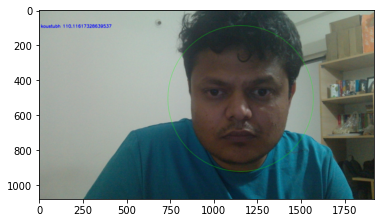

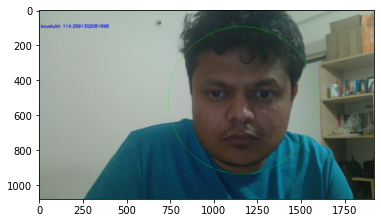

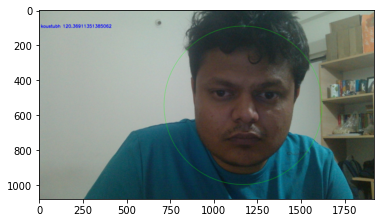

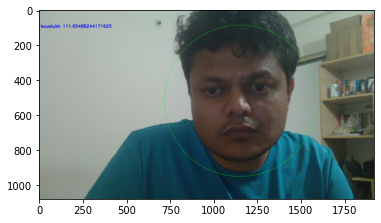

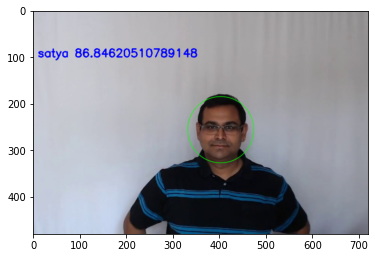

In [19]:
# We will display only 5 results
count = 0
while (VIDEO or (i < len(testFiles))) and (count < 5):
    if VIDEO:
      success, original = cam.read()
      original = cv2.resize(original, (640, 480))
      if not success:
        print('cannot capture input from camera')
        break

    else:
      imagePath = testFiles[i]
      original = cv2.imread(imagePath)
      i += 1

    im = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)

    imHeight, imWidth = im.shape[:2]

    # Find landmarks.
    landmarks = fbc.getLandmarks(faceDetector, landmarkDetector, im)
    landmarks = np.array(landmarks)
    if len(landmarks) < 68:
      print("Only {} Landmarks located".format(len(landmarks)))
      continue

    x1Limit = landmarks[0][0] - (landmarks[36][0] - landmarks[0][0])
    x2Limit = landmarks[16][0] + (landmarks[16][0] - landmarks[45][0])
    y1Limit = landmarks[27][1] - 3*(landmarks[30][1] - landmarks[27][1])
    y2Limit = landmarks[8][1] + (landmarks[30][1] - landmarks[29][1])

    x1 = max(x1Limit,0)
    x2 = min(x2Limit, imWidth)
    y1 = max(y1Limit, 0)
    y2 = min(y2Limit, imHeight)
    imFace = im[y1:y2, x1:x2]

    alignedFace = alignFace(imFace, landmarks)
    alignedFace = cv2.resize(alignedFace, (faceHeight, faceWidth))
    imFaceFloat = np.float32(alignedFace)/255.0

    predictedLabel = -1
    predictedLabel, score = faceRecognizer.predict(imFaceFloat)
    center = ( int((x1 + x2) /2), int((y1 + y2)/2) )
    radius = int((y2-y1)/2.0)
    cv2.circle(original, center, radius, (0, 255, 0), 1, lineType=cv2.LINE_AA);
    cv2.putText(original, '{} {}'.format(labelsMap[predictedLabel],score), (10,100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2);

    plt.imshow(original[:,:,::-1])
    plt.show()
    count += 1

# <font style = "color:rgb(50,120,229)">References and Further Reading</font>

1. [OpenCV FaceRec Tutorial](https://docs.opencv.org/3.3.1/da/d60/tutorial_face_main.html)

2. [OpenCV FaceRec Documentation](https://docs.opencv.org/3.3.1/db/d7c/group__face.html)

3. [http://www.face-rec.org/databases/](http://www.face-rec.org/databases/)

4. [http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)